In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

-----
<p style='color:red'> # 1. train_users.csv & test_users.csv</p>
-----

In [2]:
train_df = pd.read_csv('./data/train_users_2.csv')
test_df = pd.read_csv('./data/test_users.csv')

In [3]:
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
train_df.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### Feature Enginnering Flow
1. datetime
2. age
3. categorical
    - One-hot encoding
        - ```pd.get_dummies()```
4. remove NaN 많은 column
    - drop

## 0. dtype transform

### 0.1. Datetime

In [5]:
train_df['date_account_created'] = pd.to_datetime(train_df.date_account_created)
test_df['date_account_created'] = pd.to_datetime(test_df.date_account_created)

In [6]:
tr_tfa_str = train_df.timestamp_first_active.values.astype('str')
train_df['timestamp_first_active'] = pd.to_datetime(tr_tfa_str)
te_tfa_str = test_df.timestamp_first_active.values.astype('str')
test_df['timestamp_first_active'] = pd.to_datetime(te_tfa_str)

### 0.2. Drop NaN columns

In [7]:
train_df.drop(['date_first_booking','country_destination'],axis=1, inplace=True)
test_df.drop(['date_first_booking'],axis=1, inplace=True)

### 0.3. Concat train_df & test_df

In [8]:
df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
df.shape

(275547, 14)

## 1. Datetime --- One-hot Encoding

### 1.1 timestamp_first_active

In [9]:
df['tfa_year'] = np.array([x.year for x in df.timestamp_first_active])
df['tfa_month'] = np.array([x.month for x in df.timestamp_first_active])
df['tfa_day'] = np.array([x.day for x in df.timestamp_first_active])

In [10]:
df['tfa_wd'] = np.array([x.isoweekday() for x in df.timestamp_first_active])
# return weekdays as 1,2,3,4,5,6,7 = mon ~ sun
tfa_wd_df = pd.get_dummies(df.tfa_wd, prefix='tfa_wd')
# return a dataframe 
df = pd.concat((df,tfa_wd_df),axis=1)
# new df = previous df + onhot-encoding df
df.drop(['tfa_wd'], axis=1, inplace=True)
# remove tfa_wd column, use onehot-encoded feature columns

In [11]:
def season(tfa):
    month = tfa.month
    if month in [3,4,5]:
        label = 'Spring'
    elif month in [6,7,8]:
        label = 'Summer'
    elif month in [9,10,11]:
        label = 'Autumn'
    else: label = 'Winter'
    return label   
    
df['tfa_season'] = df.timestamp_first_active.apply(season)
tfa_season_df = pd.get_dummies(df.tfa_season, prefix='tfa_season')
df = pd.concat((df, tfa_season_df),axis=1)
df.drop(['tfa_season'],axis=1,inplace=True)

### 1.2 date_account_created

In [12]:
df['dac_year'] = np.array([x.year for x in df.date_account_created])
df['dac_month'] = np.array([x.month for x in df.date_account_created])
df['dac_day'] = np.array([x.day for x in df.date_account_created])

In [13]:
df['dac_wd'] = np.array([x.isoweekday() for x in df.date_account_created])
dac_wd_df = pd.get_dummies(df.dac_wd, prefix='dac_wd')
df = pd.concat((df,dac_wd_df),axis=1)
df.drop(['dac_wd'],axis=1,inplace=True)

In [14]:
df['dac_season'] = df.date_account_created.apply(season)
dac_season_df = pd.get_dummies(df.dac_season,prefix='dac_season')
df = pd.concat((df,dac_season_df),axis=1)
df.drop(['dac_season'],axis=1,inplace=True)

In [15]:
df.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,dac_wd_2,dac_wd_3,dac_wd_4,dac_wd_5,dac_wd_6,dac_wd_7,dac_season_Autumn,dac_season_Spring,dac_season_Summer,dac_season_Winter
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,NaN,facebook,0,en,direct,direct,...,0,0,0,0,0,0,0,0,1,0
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38.0,facebook,0,en,seo,google,...,0,1,0,0,0,0,0,1,0,0
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56.0,basic,3,en,direct,direct,...,1,0,0,0,0,0,1,0,0,0
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42.0,facebook,0,en,direct,direct,...,0,0,0,0,0,0,0,0,0,1
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.0,basic,0,en,direct,direct,...,1,0,0,0,0,0,1,0,0,0


In [16]:
df.columns

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'tfa_year', 'tfa_month',
       'tfa_day', 'tfa_wd_1', 'tfa_wd_2', 'tfa_wd_3', 'tfa_wd_4', 'tfa_wd_5',
       'tfa_wd_6', 'tfa_wd_7', 'tfa_season_Autumn', 'tfa_season_Spring',
       'tfa_season_Summer', 'tfa_season_Winter', 'dac_year', 'dac_month',
       'dac_day', 'dac_wd_1', 'dac_wd_2', 'dac_wd_3', 'dac_wd_4', 'dac_wd_5',
       'dac_wd_6', 'dac_wd_7', 'dac_season_Autumn', 'dac_season_Spring',
       'dac_season_Summer', 'dac_season_Winter'],
      dtype='object')

### 1.3 Time Span between dac and tfa

In [17]:
# Series.dt.day -> The days of the datetime

In [18]:
dt_span = df.date_account_created.subtract(df.timestamp_first_active).dt.days

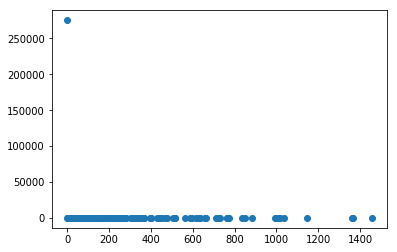

In [19]:
plt.scatter(dt_span.value_counts().index, dt_span.value_counts().values)

In [20]:
def time_span(var):
    if var == -1:
        label = 'Oneday'
    elif var <= 30:
        label = 'Onemonth'
    elif var <= 365:
        label = 'Oneyear'
    else: label = 'Other'
    return label

time_span_label = dt_span.apply(time_span)

In [21]:
time_span_label.value_counts()

Oneday      275369
Oneyear         88
Other           47
Onemonth        43
dtype: int64

In [22]:
df['time_span'] = time_span_label

In [23]:
time_span_df = pd.get_dummies(df.time_span, prefix='time_span')
df = pd.concat((df,time_span_df),axis=1)
df.drop(['time_span'],axis=1,inplace=True)

### 1.4 Remove dac & tfa columns after feature enginnering

In [24]:
df.drop(['date_account_created','timestamp_first_active'],axis=1,inplace=True)

## 2.  Age --- One-hot Encoding

In [25]:
df['age'].fillna(-1,inplace=True)

In [26]:
df.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,dac_wd_6,dac_wd_7,dac_season_Autumn,dac_season_Spring,dac_season_Summer,dac_season_Winter,time_span_Oneday,time_span_Onemonth,time_span_Oneyear,time_span_Other
0,gxn3p5htnn,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,...,0,0,0,0,1,0,0,0,0,1
1,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,untracked,Web,...,0,0,0,1,0,0,0,0,0,1
2,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,...,0,0,1,0,0,0,0,0,0,1
3,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,...,0,0,0,0,0,1,0,0,0,1
4,87mebub9p4,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,...,0,0,1,0,0,0,0,0,1,0


In [27]:
age_series = df['age']

In [28]:
def age(val):
    if (val>1900)&(val<2010):
        label = 2018-val
    else: label = val
    return label

age_no_1000 = age_series.apply(age)

In [29]:
def age_range(age):
    base = 15
    if age == -1:
        label = 'NaN'
    elif age < base:
        label = base
    elif age < base *2:
        label = base *2
    elif age < base *3:
        label = base *3
    elif age < base *4:
        label = base *4
    elif age < base *5:
        label = base *5
    elif age < base *6:
        label = base *6
    elif age < base *7:
        label = base *7
    else: label = 'Unpysical'
    return label

age_label = age_no_1000.apply(age_range)
age_label.value_counts()

NaN          116866
45            72824
30            51760
60            23171
75             7247
Unpysical      2450
90              724
105             445
15               60
Name: age, dtype: int64

In [30]:
age_label_df = pd.get_dummies(age_label, prefix='age')
df = pd.concat((df,age_label_df),axis=1)

In [31]:
df.drop(['age'],axis=1,inplace=True)

-----
**Issue - no use --- np.where()**

```python
age = df['age'].values
age = np.where(np.logical_and(age<2010,age>1990), 2018-age, age)
age.max() => 2014
```
eg:

```arr = np.random.randn(4,4)```

```
array([[-0.32265205,  0.53133885, -1.0850594 ,  0.89857162],
       [ 0.54831018, -0.81251017, -1.14540716,  1.66426604],
       [ 0.77844041,  2.07283316, -0.32183705, -0.70056285],
       [-0.99258249, -0.32509112, -0.95094696,  0.77907217]])
```
       
       
```np.where(arr<0, -1, 1)```
```
array([[-1,  1, -1,  1],
       [ 1, -1, -1,  1],
       [ 1,  1, -1, -1],
       [-1, -1, -1,  1]])
```
-----

In [32]:
df.head()

,id,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,...,time_span_Other,age_15,age_30,age_45,age_60,age_75,age_90,age_105,age_NaN,age_Unpysical
0,gxn3p5htnn,-unknown-,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,...,1,0,0,0,0,0,0,0,1,0
1,820tgsjxq7,MALE,facebook,0,en,seo,google,untracked,Web,Mac Desktop,...,1,0,0,1,0,0,0,0,0,0
2,4ft3gnwmtx,FEMALE,basic,3,en,direct,direct,untracked,Web,Windows Desktop,...,1,0,0,0,1,0,0,0,0,0
3,bjjt8pjhuk,FEMALE,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,...,1,0,0,1,0,0,0,0,0,0
4,87mebub9p4,-unknown-,basic,0,en,direct,direct,untracked,Web,Mac Desktop,...,0,0,0,1,0,0,0,0,0,0


## 3. Categorical features --- One-hot Encoding

In [33]:
cate_feats = ['gender', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser']

In [34]:
for feat in cate_feats:
    feat_df = pd.get_dummies(df[feat], prefix=feat,dummy_na=True)
    df.drop([feat],axis=1,inplace=True)
    df = pd.concat((df,feat_df),axis=1)

In [35]:
df.shape

(275547, 205)

In [36]:
df.head()

,id,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,...,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser,first_browser_nan
0,gxn3p5htnn,2009,3,19,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,820tgsjxq7,2009,5,23,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,2009,6,9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,2009,10,31,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,2009,12,8,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


-----
<p style='color:red'> # 2. sessions.csv</p>
-----

In [85]:
session_df = pd.read_csv('./data/sessions.csv')

In [86]:
session_df.shape

(10567737, 6)

In [87]:
session_df['id'] = session_df.user_id
session_df.drop(['user_id'],axis=1,inplace=True)
# session_df.set_index('id',inplace=True)

In [88]:
session_df.isnull().sum()

action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
id                 34496
dtype: int64

In [89]:
session_df.fillna('NaN',inplace=True)

## 1. action

In [90]:
session_df.action.value_counts()

show                           2768278
index                           843699
search_results                  725226
personalize                     706824
search                          536057
ajax_refresh_subtotal           487744
update                          365130
similar_listings                364624
social_connections              339000
reviews                         320591
active                          188036
similar_listings_v2             168788
lookup                          162041
create                          155887
dashboard                       152952
header_userpic                  141830
collections                     124417
edit                            109083
campaigns                       105028
track_page_view                  81117
NaN                              79626
unavailabilities                 78317
qt2                              64651
notifications                    59392
confirm_email                    58726
requested                

In [91]:
act_dict = dict(zip(session_df.action.value_counts().index,session_df.action.value_counts().values))

In [92]:
act_dict

{'10': 3215,
 '11': 716,
 '12': 2209,
 '15': 1053,
 'NaN': 79626,
 'about_us': 416,
 'accept_decline': 2,
 'account': 9040,
 'acculynk_bin_check_failed': 1,
 'acculynk_bin_check_success': 51,
 'acculynk_load_pin_pad': 50,
 'acculynk_pin_pad_error': 4,
 'acculynk_pin_pad_inactive': 30,
 'acculynk_pin_pad_success': 5,
 'acculynk_session_obtained': 52,
 'active': 188036,
 'add_business_address_colorbox': 9,
 'add_guest_colorbox': 7,
 'add_guests': 60,
 'add_note': 961,
 'agree_terms_check': 10938,
 'agree_terms_uncheck': 598,
 'airbnb_picks': 278,
 'airbrb': 3,
 'ajax_check_dates': 52517,
 'ajax_get_referrals_amt': 11306,
 'ajax_get_results': 369,
 'ajax_google_translate': 290,
 'ajax_google_translate_description': 933,
 'ajax_google_translate_reviews': 951,
 'ajax_image_upload': 13570,
 'ajax_ldp': 19,
 'ajax_lwlb_contact': 33413,
 'ajax_payout_edit': 714,
 'ajax_payout_options_by_country': 685,
 'ajax_payout_split_edit': 7,
 'ajax_photo_widget': 8,
 'ajax_photo_widget_form_iframe': 2444

In [93]:
act_freq = 100
# a = session_df.action.apply(lambda x:'Other' if act_dict[x]<act_freq else x)
# donno how does lambda works...???

In [94]:
def act_freq(var):
    if act_dict[var] < 100:
        label = 'OTHER'
#     elif act_dict[var] > 100000:
#         label = 'TEST'
    else: label = var
    return label

session_df['action'] = session_df.action.apply(act_freq)

In [98]:
session_df.query('action=="OTHER"')

,action,action_type,action_detail,device_type,secs_elapsed,id
142,OTHER,-unknown-,-unknown-,Windows Desktop,169295,4grx6yxeby
327,OTHER,-unknown-,-unknown-,Windows Desktop,63154,5f45ro5uzk
2346,OTHER,-unknown-,-unknown-,iPad Tablet,4951,s9xrwtyzsq
2460,OTHER,-unknown-,-unknown-,Mac Desktop,21816,1ltangt0hg
2909,OTHER,-unknown-,-unknown-,iPhone,727,toga865pvz
2938,OTHER,-unknown-,-unknown-,iPhone,30,toga865pvz
3206,OTHER,-unknown-,-unknown-,iPhone,427,toga865pvz
3272,OTHER,-unknown-,-unknown-,iPhone,294,toga865pvz
3323,OTHER,-unknown-,-unknown-,iPhone,43,toga865pvz
3334,OTHER,-unknown-,-unknown-,iPhone,1464,toga865pvz


In [101]:
session_df.action.value_counts()

show                                       2768278
index                                       843699
search_results                              725226
personalize                                 706824
search                                      536057
ajax_refresh_subtotal                       487744
update                                      365130
similar_listings                            364624
social_connections                          339000
reviews                                     320591
active                                      188036
similar_listings_v2                         168788
lookup                                      162041
create                                      155887
dashboard                                   152952
header_userpic                              141830
collections                                 124417
edit                                        109083
campaigns                                   105028
track_page_view                